# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [29]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import scipy.ndimage as ndi
import matplotlib.pyplot as plt

from data import data_helper
from data.data_helper import Phase

import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.exceptions import ConvergenceWarning

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Model Choice

Diagnosis of the wanted disease is normally made based on structural characteristics, such as ventricle volumes and myocard thickness.
Since segmentation masks are given, they can be used to calculate these metrics directly and use them as features for a classical ML model, e.g. a SVM


## Feature Selection

[Indicate which features from the dataset you will be using for the baseline model, and justify your selection.]


In [22]:
def compute_MC_thickness(lv_mask, myo_mask, voxel_spacing=(1., 1., 1.), num_angles=360, num_slices=None):
    """
    Simplified computation of myocardial thickness in 3D.

    Parameters:
    - lv_mask: 3D binary NumPy array of the LV segmentation mask
    - myo_mask: 3D binary NumPy array of the myocardium segmentation mask
    - voxel_spacing: Tuple (dx, dy, dz) for voxel dimensions (default: isotropic 1mm spacing)
    - num_angles: Number of angles for radial sampling (default: 360)
    - num_slices: Number of slices to process (default: all)

    Returns:
    - thickness_map: 3D array with myocardial thickness values (in mm)
    - mean_thickness: Average myocardial thickness (in mm)
    """
    height, width, depth = lv_mask.shape
    slice_indices = np.linspace(0, depth - 1, num_slices, dtype=int) if num_slices else range(depth)

    # Polar angle sampling
    angles = np.linspace(0, 2 * np.pi, num_angles)
    thickness_map = np.zeros((len(slice_indices), num_angles), dtype=np.float32)

    for i, z in enumerate(slice_indices):
        lv_slice = lv_mask[:, :, z]
        myo_slice = myo_mask[:, :, z]

        # Skip slices without LV
        if not lv_slice.any():
            continue

        # Compute LV centroid
        y_coords, x_coords = np.where(lv_slice > 0)
        lv_center = (np.mean(x_coords), np.mean(y_coords))

        # Compute distance transforms
        dist_inner = ndi.distance_transform_edt(lv_slice)  # LV boundary
        dist_outer = ndi.distance_transform_edt(lv_slice | myo_slice)  # Myocardial boundary

        for k, theta in enumerate(angles):
            dx, dy = np.cos(theta), np.sin(theta)

            # Traverse outward along the ray
            for r in range(1, max(height, width)):
                x = int(lv_center[0] + r * dx)
                y = int(lv_center[1] + r * dy)

                if 0 <= x < width and 0 <= y < height:
                    # Check distances at the current ray point
                    if dist_inner[y, x] > 0 and dist_outer[y, x] > 0:
                        thickness = dist_outer[y, x] - dist_inner[y, x]
                        thickness_map[i, k] = thickness * voxel_spacing[0]
                        break  # Found inner and outer boundaries, stop ray traversal

    # Calculate mean thickness
    thickness_map = np.where(thickness_map > 0, thickness_map, np.nan)

    return thickness_map


# compute the volume by summing up the segmented voxels
def compute_volumes(mask, voxel_spacing=(1,1,1)):
    voxel_volume = np.prod(voxel_spacing)
    vol = voxel_volume * np.sum(mask > 0)
    vol /= 1000.  # convert to cm3
    return vol

In [3]:
train_data = data_helper.load_all_patients('../data/train', load_imgs=True, return_df=True)
mask_labels = ['RV', 'MC', 'LV']

In [71]:
def create_features(data):
    features = []
    for sid, subj in data.iterrows():
        subj_features = {'id': sid}
        if 'label' in subj:
            subj_features['label'] = subj['label']
        for phase in [Phase.SYS, Phase.DIA]:
            seg_mask = subj[f'{phase}_seg']
            spacing = subj[f'{phase}_seg_header'].get_zooms()
            for k, mask_label in enumerate(mask_labels):
                volume = compute_volumes(seg_mask==k+1, spacing)
                subj_features[f'{mask_label}_{phase}'] = volume
            lv_mask = (seg_mask==2)
            myo_mask = (seg_mask==3)
            myo_thickness = compute_MC_thickness(lv_mask, myo_mask, spacing)
            subj_features[f'MT_{phase}_max'] = np.nanmax(myo_thickness)
            subj_features[f'MT_{phase}_mean'] = np.nanmean(myo_thickness)
        features.append(subj_features)
    features_df = pd.DataFrame(features).set_index('id')
    features_df['SV'] = features_df['LV_sys'] - features_df['LV_dia']
    features_df['EF'] = 100*features_df['SV'] / features_df['LV_sys']
    features_df = features_df.rename(columns={'RV_sys': 'ESV_R', 'RV_dia': 'EDV_R',
                                              'LV_sys': 'ESV_L', 'LV_dia': 'EDV_L'})
    return features_df

features_df = create_features(train_data)
display(features_df.groupby('label').mean().round(1))

,ESV_R,MC_sys,ESV_L,MT_sys_max,MT_sys_mean,EDV_R,MC_dia,EDV_L,MT_dia_max,MT_dia_mean,SV,EF
label,,,,,,,,,,,,
DCM,186.1,158.0,275.6,11.000000,5.7,128.6,168.5,224.9,13.200000,7.1,50.7,19.1
HCM,121.2,167.9,127.9,19.799999,9.3,47.7,192.4,42.0,24.299999,15.9,86.0,67.2
MINF,126.2,129.2,189.3,12.200000,6.0,58.3,143.4,131.8,16.799999,8.3,57.5,30.6
NOR,147.7,94.1,130.8,10.100000,5.1,69.2,109.0,51.0,15.300000,9.6,79.9,61.1
RV,220.6,81.6,125.5,9.700000,4.5,139.6,91.0,54.0,14.000000,8.0,71.5,57.5


<Axes: >

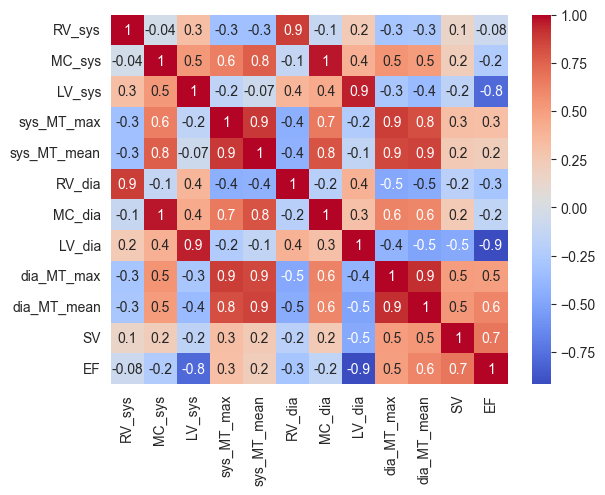

In [25]:
import seaborn as sns
sns.heatmap(features_df.corr(numeric_only=True), cmap='coolwarm', annot=True, fmt='.1g')

## Implementation

[Implement your baseline model here.]



In [41]:
# Let's first try a simple SVM model

# Prepare the data
X = features_df.drop(columns=['label'])
y = features_df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

classifier = SVC(kernel='rbf', random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         DCM       0.60      0.75      0.67         4
         HCM       1.00      0.75      0.86         4
        MINF       0.67      0.50      0.57         4
         NOR       0.67      1.00      0.80         4
          RV       1.00      0.75      0.86         4

    accuracy                           0.75        20
   macro avg       0.79      0.75      0.75        20
weighted avg       0.79      0.75      0.75        20



In [58]:
X = features_df.drop(columns=['label'])
y = features_df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

classifier = DecisionTreeClassifier(random_state=42, max_depth=3)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         DCM       0.50      0.75      0.60         4
         HCM       1.00      1.00      1.00         4
        MINF       0.50      0.25      0.33         4
         NOR       0.80      1.00      0.89         4
          RV       1.00      0.75      0.86         4

    accuracy                           0.75        20
   macro avg       0.76      0.75      0.74        20
weighted avg       0.76      0.75      0.74        20



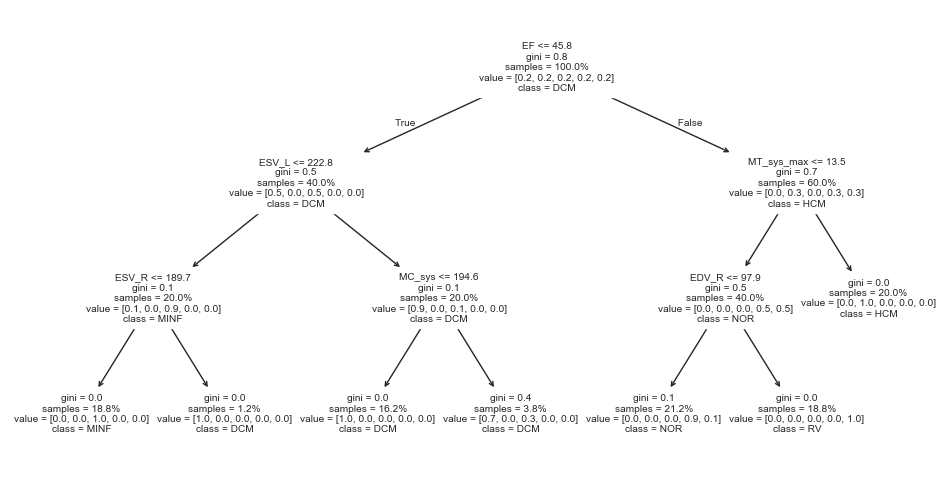

In [60]:
plt.figure(figsize=(12,6))
sklearn.tree.plot_tree(classifier, feature_names=X.columns, class_names=np.unique(y_pred), proportion=True, precision=1)
plt.show()

This is already pretty good! Let's test some other models and use GridSearchCV to find a good one

In [54]:
import warnings
# comment out the next line to see ConvergenceWarnings
warnings.simplefilter('ignore', category=ConvergenceWarning)

# Assuming 'df' is already created as in the provided code.
# Prepare the data
X = features_df.drop(['label'], axis=1)
y = features_df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the classifiers and their parameter grids
classifiers = {
    'LogisticRegression': (LogisticRegression(random_state=42, max_iter=10000, tol=0.1),
                           {'classifier__C': np.logspace(-3, 3, 7),}),
    'SVM': (SVC(random_state=42),
            {'classifier__C': [0.01, 0.1, 1, 10, 100], 'classifier__kernel': ['linear', 'rbf', 'poly']}),
    'DecisionTree': (DecisionTreeClassifier(random_state=42),
                     {'classifier__criterion': ['gini', 'entropy'],
                      'classifier__max_depth': [None, 5, 10, 20]}),
    'RandomForest': (RandomForestClassifier(random_state=42),
                     {'classifier__n_estimators': [10, 25, 50],
                      'classifier__max_depth': [None, 5, 10, 20]}),
    'GradientBoosting': (GradientBoostingClassifier(random_state=42),
                         {'classifier__n_estimators': [10, 25, 50],
                          'classifier__learning_rate': [0.01, 0.1, 1]}),
    'MLPClassifier': (MLPClassifier(random_state=42, max_iter=500), # Increased max_iter
                      {'classifier__hidden_layer_sizes': [(32), (64), (16,32), (32,64)],
                       'classifier__alpha': [0.0001, 0.001]})
}

# Perform stratified k-fold cross-validation and grid search
best_classifier = None
best_score = 0
best_model = None


for name, (classifier, param_grid) in classifiers.items():
    pipeline = Pipeline([
        ('scaler', 'MinMaxScaler'),  # Use MinMaxScaler for feature scaling
        ('reducer', 'passthrough'),
        ('classifier', classifier)
    ])
    # add different normalization schemes to the grid search
    param_grid = dict(**param_grid,
                      scaler = [MinMaxScaler(), StandardScaler(), 'passthrough'],
                      reducer = [PCA(3), PCA(5), 'passthrough'])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1_weighted')  # Use f1_weighted as the scoring metric
    grid_search.fit(X_train, y_train)

    print(f"Results for {name}:")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

    if grid_search.best_score_ > best_score:
      best_score = grid_search.best_score_
      best_model = grid_search.best_estimator_
      best_classifier = name


print(f"\nBest classifier: {best_classifier}")

# Evaluate the best classifier on the test set
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Results for LogisticRegression:
Best parameters: {'classifier__C': 1.0, 'reducer': PCA(n_components=5), 'scaler': MinMaxScaler()}
Best cross-validation score: 0.872
Results for SVM:
Best parameters: {'classifier__C': 10, 'classifier__kernel': 'linear', 'reducer': 'passthrough', 'scaler': MinMaxScaler()}
Best cross-validation score: 0.937
Results for DecisionTree:
Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'reducer': PCA(n_components=5), 'scaler': 'passthrough'}
Best cross-validation score: 0.913
Results for RandomForest:
Best parameters: {'classifier__max_depth': 5, 'classifier__n_estimators': 50, 'reducer': PCA(n_components=3), 'scaler': 'passthrough'}
Best cross-validation score: 0.911
Results for GradientBoosting:
Best parameters: {'classifier__learning_rate': 1, 'classifier__n_estimators': 10, 'reducer': 'passthrough', 'scaler': MinMaxScaler()}
Best cross-validation score: 0.881
Results for MLPClassifier:
Best parameters: {'classifier__alpha':

## Evaluation

[Clearly state what metrics you will use to evaluate the model's performance. These metrics will serve as a starting point for evaluating more complex models later on.]



In [8]:
# Evaluate the best classifier on the test set
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         DCM       0.57      1.00      0.73         4
         HCM       1.00      0.75      0.86         4
        MINF       1.00      0.25      0.40         4
         NOR       0.80      1.00      0.89         4
          RV       1.00      1.00      1.00         4

    accuracy                           0.80        20
   macro avg       0.87      0.80      0.77        20
weighted avg       0.87      0.80      0.77        20



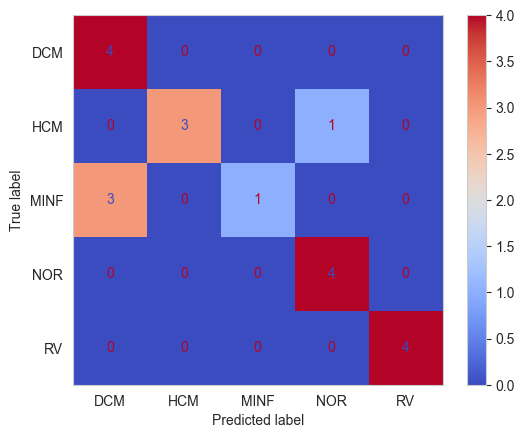

In [56]:
#confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='coolwarm')
plt.grid(False)
plt.show()

In [72]:
test_data = data_helper.load_all_patients('../data/test', load_imgs=True, return_df=True)
test_features_df = create_features(test_data)
test_features_df.head(3)

,ESV_R,MC_sys,ESV_L,MT_sys_max,MT_sys_mean,EDV_R,MC_dia,EDV_L,MT_dia_max,MT_dia_mean,SV,EF
id,,,,,,,,,,,,
p0101,177.890625,88.699219,145.722656,9.058035,4.158973,69.855469,86.203125,49.500000,11.775206,7.745956,96.222656,66.031363
p0102,125.548821,98.160758,106.996328,11.875040,6.571905,66.850671,126.606446,29.591447,20.432228,13.413817,77.404881,72.343493
p0103,181.339859,130.495346,135.007431,10.473040,6.701899,99.641876,160.304352,60.766922,18.633610,11.496786,74.240509,54.989943


In [77]:
y_pred = best_model.predict(test_features_df)
pd.Series(y_pred, index=test_features_df.index, name='label').to_csv("submission.csv")

id
p0101     NOR
p0102     NOR
p0103     NOR
p0104     DCM
p0105    MINF
p0106     DCM
p0107    MINF
p0108    MINF
p0109    MINF
p0110     NOR
p0111    MINF
p0112     DCM
p0113    MINF
p0114      RV
p0115     DCM
p0116      RV
p0117     NOR
p0118     NOR
p0119      RV
p0120     HCM
p0121      RV
p0122     DCM
p0123     DCM
p0124      RV
p0125     HCM
p0126     HCM
p0127     HCM
p0128     DCM
p0129     DCM
p0130     NOR
p0131     NOR
p0132     NOR
p0133     NOR
p0134    MINF
p0135     HCM
p0136    MINF
p0137     HCM
p0138     HCM
p0139      RV
p0140    MINF
p0141     NOR
p0142     DCM
p0143      RV
p0144      RV
p0145      RV
p0146     HCM
p0147     HCM
p0148     HCM
p0149     DCM
p0150    MINF
Name: label, dtype: object